In [1]:
from myai.imports import *
from visualbench.tasks.function_descent import FunctionDescent
from visualbench.tasks.box_packing import BoxPacking
from visualbench.tasks.inverse import MatrixInverse
from myai.aicode.deepseek import *
import torchzero as tz, torch

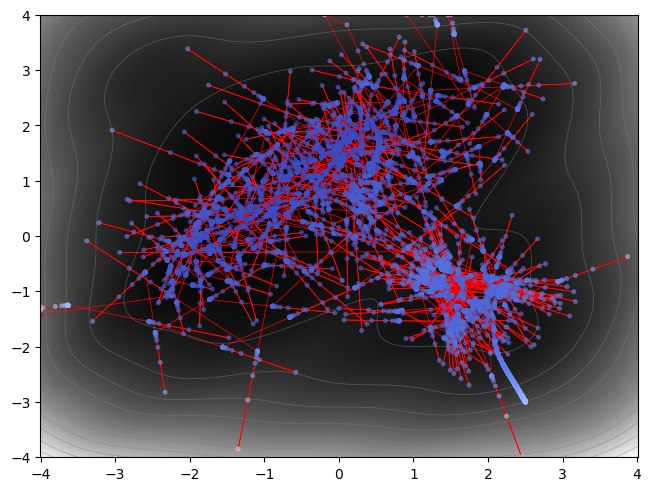

In [9]:
bench = FunctionDescent('nonconvex')
opt = BouncyBall(bench.parameters(), 0.1,)
bench.run(opt, 10000)
bench.plot_solution()

In [17]:
bench.render_video('BALL30', 30)

1000/1000 | 8.90s                


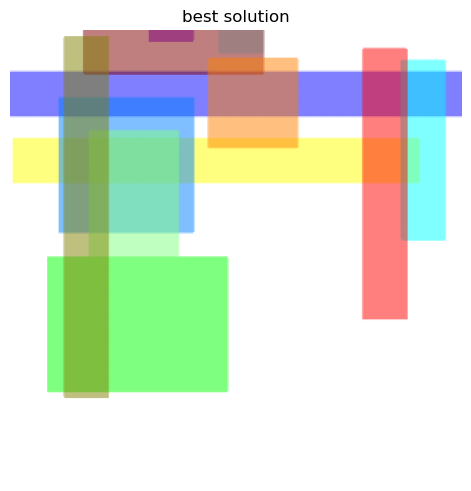

In [15]:
bench = BoxPacking()
opt = BouncyBall(bench.parameters(), 0.02)
bench.run(opt, 1000)
bench.plot_solution()

In [16]:
bench.render_video('BALLLLL', 30)

1000/1000 | 10.76s               


image.shape = torch.Size([3, 229, 229]), image.numel() = 157323


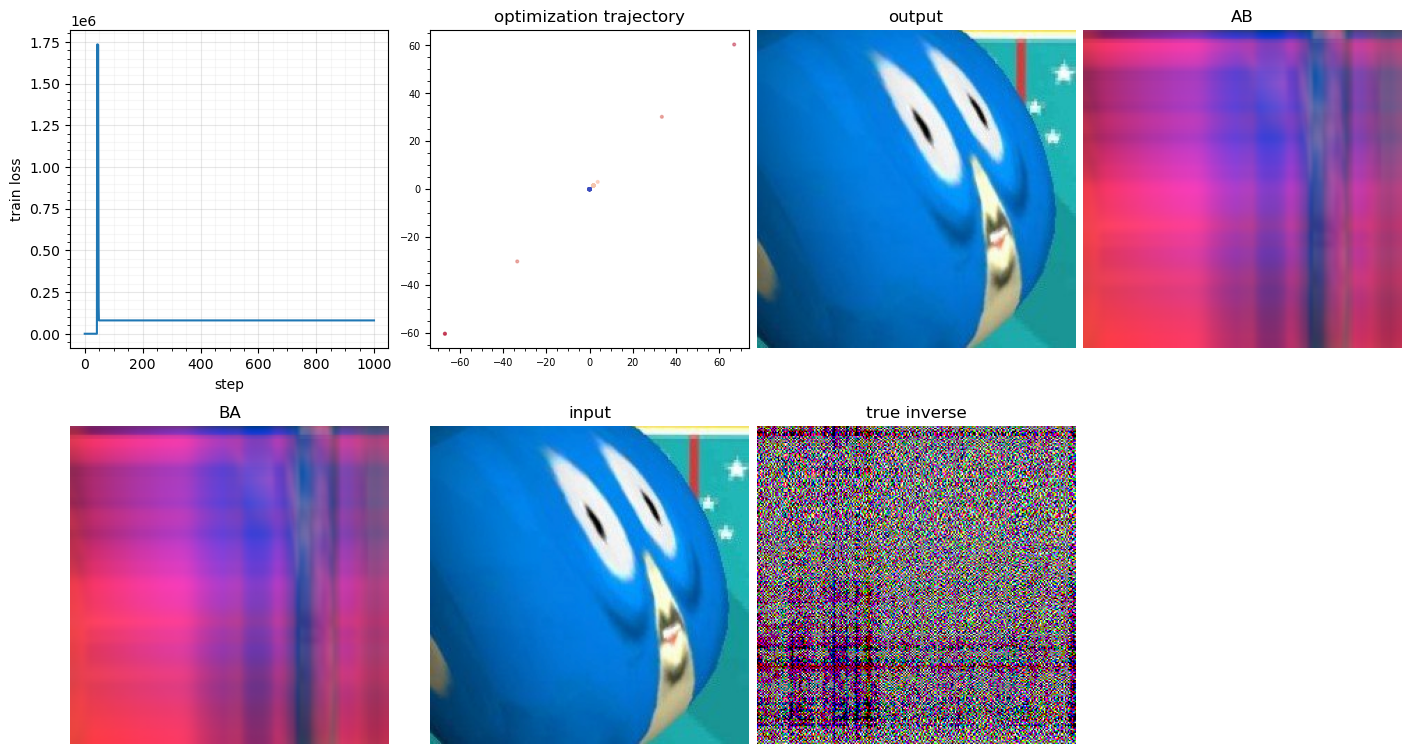

In [4]:
REDUCTION = 0
BW = False

image = znormalize(imreadtensor('/var/mnt/ssd/Файлы/Изображения/Сохраненное/sanic.jpg').float())
if REDUCTION > 1:
    image = image[:,::REDUCTION,::REDUCTION].clone()
if BW: image = image.mean(0)

print(f'{image.shape = }, {image.numel() = }')
bench = MatrixInverse(image)
opt = RaySubspace(bench.parameters(), 100, max_ls_iter=1)
bench.run(opt, 1000)
bench.plot_summary()

In [9]:
bench.render_video('why bro3', scale=2)

1000/1000 | 9.43s               


In [157]:
import torch

class Simulation:
    def __init__(self, objective_function, initial_coords, initial_height,
                 dt, gravity, bounciness, air_resistance, wall_threshold):
        self.objective = objective_function
        self.n = len(initial_coords)
        self.position = torch.zeros(self.n + 1)
        self.position[:self.n] = torch.tensor(initial_coords, dtype=torch.float)
        loss, grad = self.objective(self.position[:self.n])
        surface_height = loss.item()
        self.position[self.n] = surface_height + initial_height
        self.velocity = torch.zeros(self.n + 1)
        self.dt = dt
        self.g = gravity
        self.e = bounciness
        self.k = air_resistance
        self.wall_threshold = wall_threshold
        self.epsilon = 1e-4  # Adjusted epsilon
        self.in_contact = True  # Flag to track contact with surface

    def step(self):
        # Get current surface height and gradient at current position
        current_coords = self.position[:self.n]
        loss, grad = self.objective(current_coords)
        surface_height = loss.item()
        
        # Determine if the ball is in contact with the surface
        in_contact = self.position[self.n] <= surface_height + self.epsilon
        
        if in_contact:
            # Compute normal vector: [grad_x, -1], normalized
            normal = torch.cat((grad, -torch.ones(1)))
            normal = normal / normal.norm()
            
            # Gravitational acceleration decomposition
            g_vector = torch.zeros_like(self.position)
            g_vector[self.n] = -self.g  # Gravity downward
            g_normal = (g_vector @ normal) * normal
            g_tangential = g_vector - g_normal
            
            # Update velocity based on forces
            acceleration = g_tangential.clone()
            # Air resistance opposes velocity
            air_acceleration = -self.k * self.velocity
            total_acceleration = acceleration + air_acceleration
        else:
            # Only gravity in z-direction and air resistance when in the air
            acceleration = torch.zeros_like(self.position)
            acceleration[self.n] = -self.g  # Gravity downward
            # Air resistance opposes velocity
            air_acceleration = -self.k * self.velocity
            total_acceleration = acceleration + air_acceleration
        
        # Update velocity using Euler integration
        self.velocity += total_acceleration * self.dt
        # Update position using Euler integration
        new_position = self.position + self.velocity * self.dt

        # Get surface height and gradient at new position
        current_coords_new = new_position[:self.n]
        loss_new, grad_new = self.objective(current_coords_new)
        surface_height_new = loss_new.item()

        # Check if the ball is below the surface with epsilon
        if new_position[self.n] < surface_height_new - self.epsilon and self.velocity[self.n] < 0:
            # Ball has gone below surface, find intersection
            x = self.position[:self.n]
            v_x = self.velocity[:self.n]
            v_z = self.velocity[self.n]
            f_x = loss.item()
            # Linear approximation: f(x + v_x * t) ≈ f(x) + grad(x) @ (v_x * t)
            # Height equation: position_z + v_z * t = f(x) + grad(x) @ (v_x * t)
            denom = v_z - torch.dot(grad, v_x) + 1e-8  # Prevent division by zero
            t = (f_x - self.position[self.n]) / denom
            if 0 <= t <= self.dt:
                # Intersection occurs at t
                intersection_pos = self.position + self.velocity * t
                # Set position to intersection_pos
                self.position = intersection_pos
                # Compute normal vector: [grad_x, -1], normalized
                normal_intersection = torch.cat((grad, -torch.ones(1)))
                normal_intersection = normal_intersection / normal_intersection.norm()
                # Reflect velocity
                v = self.velocity
                v_normal = (v @ normal_intersection) * normal_intersection
                v_tangent = v - v_normal
                # Bounce: reverse the normal component with bounciness
                v_reflected = v_tangent - self.e * v_normal
                self.velocity = v_reflected
                print("Ball bounced after flying.")
                self.in_contact = False  # After bouncing, ball is airborne
            else:
                # No intersection within the time step, set position to surface height
                self.position = new_position
                self.position[self.n] = surface_height_new
                # Project velocity onto tangent plane
                normal_new = torch.cat((grad_new, -torch.ones(1)))
                normal_new = normal_new / normal_new.norm()
                v = self.velocity
                v_normal = (v @ normal_new) * normal_new
                v_tangent = v - v_normal
                self.velocity = v_tangent
                self.in_contact = True  # Ball is back in contact
        else:
            # Ball is above surface, set position to new_position
            self.position = new_position
            # Check for wall bouncing based on gradient magnitude
            grad_norm = grad.norm()
            if grad_norm > self.wall_threshold:
                # Treat as a wall: bounce off
                normal_wall = grad / grad_norm  # Outward normal
                v = self.velocity[:self.n]
                v_normal = (v @ normal_wall) * normal_wall
                v_tangent = v - v_normal
                # Bounce: reverse the normal component with bounciness
                v_reflected = v_tangent - self.e * v_normal
                self.velocity[:self.n] = v_reflected
                print("Ball bounced after hitting a wall.")
                self.in_contact = False  # After wall bounce, ball may be airborne
            # Check if the ball is flying into the air
            if self.velocity[self.n] > 0 and not self.in_contact:
                print("Ball is flying into the air.")
                self.in_contact = False
            else:
                self.in_contact = in_contact

    def get_position(self):
        return self.position.clone()

    def set_position(self, new_position):
        self.position = new_position.clone()
        
# Example usage:
# Define an objective function, for example, a sphere function
def sphere_function(x):
    loss = torch.sum(x**2)
    grad = 2 * x
    return loss, grad

# Initialize simulation parameters
initial_coords = torch.tensor([1.0, 1.0])  # 2D example
initial_height = 10.0  # Starting above the surface
dt = 0.001  # Reduced time step for stability
gravity = 9.81
bounciness = 0.8
air_resistance = 0.1
wall_threshold = 10.0  # Arbitrary threshold

# Create simulation instance
sim = Simulation(sphere_function, initial_coords, initial_height,
                 dt, gravity, bounciness, air_resistance, wall_threshold)


# Run simulation steps
for _ in range(2000):
    print(_)
    print(f'{sim.position}, {sim.velocity}')
    sim.step()
    # Optionally, print or record position
    # print(sim.get_position())



/tmp/ipykernel_316275/3795010684.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.position[:self.n] = torch.tensor(initial_coords, dtype=torch.float)


0
tensor([ 1.,  1., 12.]), tensor([0., 0., 0.])
1
tensor([ 1.0000,  1.0000, 12.0000]), tensor([ 0.0000,  0.0000, -0.0098])
2
tensor([ 1.0000,  1.0000, 12.0000]), tensor([ 0.0000,  0.0000, -0.0196])
3
tensor([ 1.0000,  1.0000, 11.9999]), tensor([ 0.0000,  0.0000, -0.0294])
4
tensor([ 1.0000,  1.0000, 11.9999]), tensor([ 0.0000,  0.0000, -0.0392])
5
tensor([ 1.0000,  1.0000, 11.9999]), tensor([ 0.0000,  0.0000, -0.0490])
6
tensor([ 1.0000,  1.0000, 11.9998]), tensor([ 0.0000,  0.0000, -0.0588])
7
tensor([ 1.0000,  1.0000, 11.9997]), tensor([ 0.0000,  0.0000, -0.0686])
8
tensor([ 1.0000,  1.0000, 11.9996]), tensor([ 0.0000,  0.0000, -0.0785])
9
tensor([ 1.0000,  1.0000, 11.9996]), tensor([ 0.0000,  0.0000, -0.0883])
10
tensor([ 1.0000,  1.0000, 11.9995]), tensor([ 0.0000,  0.0000, -0.0981])
11
tensor([ 1.0000,  1.0000, 11.9994]), tensor([ 0.0000,  0.0000, -0.1079])
12
tensor([ 1.0000,  1.0000, 11.9992]), tensor([ 0.0000,  0.0000, -0.1177])
13
tensor([ 1.0000,  1.0000, 11.9991]), tensor([ 

/tmp/ipykernel_316275/3795010684.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.position[:self.n] = torch.tensor(initial_coords, dtype=torch.float)


Ball bounced after flying.
Ball bounced after flying.


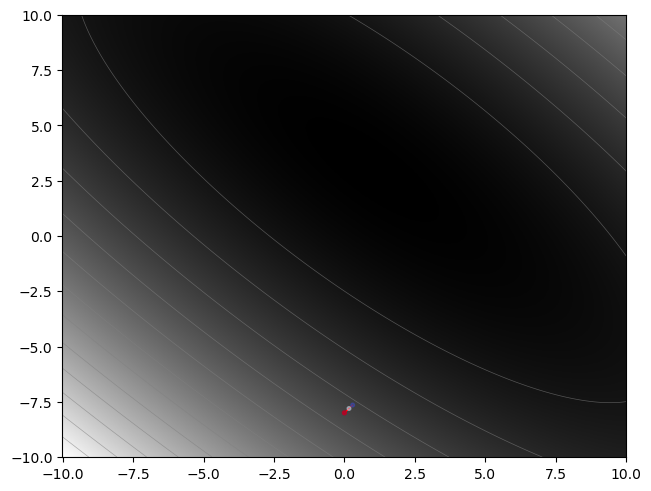

In [161]:
class BouncyBallV2(tz.core.TensorListOptimizer):
    def __init__(self, params):
        super().__init__(params, {})
        self.simulation = None

    @torch.no_grad
    def _objective(self, vec):
        p = self.get_params()
        p.from_vec_(vec)
        with torch.enable_grad(): loss = self.closure(True)
        grad = p.grad.to_vec()
        return loss, grad

    @torch.no_grad
    def step(self, closure):
        self.closure = closure
        
        if self.simulation is None:
            p = self.get_params()
            vec = p.to_vec()
            self.simulation = Simulation(self._objective, vec, 0.,
                 2., gravity, bounciness, air_resistance, wall_threshold)
            
        self.simulation.step()


bench = FunctionDescent('booth')
opt = BouncyBallV2(bench.parameters())
bench.run(opt, 5)
bench.plot_solution()

In [1]:
import numpy as np
from scipy.optimize import fixed_point

# Define the function f(x)
def f(x):
    return (x + 1)**2 # Example function with minimum at x=0

# Define the derivative of the function f'(x)
def df(x):
    return 2*(x+1)  # Derivative of x^2 is 2x

# Define g(x) = x - f'(x)
def g(x):
    return x - df(x)

# Initial guess
x0 = np.array([2., 3.])

# Find the fixed point of g(x)
minima = fixed_point(func=g, x0=x0)

print("The minimum occurs at x =", minima)

The minimum occurs at x = [-1. -1.]


In [39]:
import torch
import torch.nn as nn

class DeterministicTunnelingOptimizer(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, tunnel_freq=1000, tunnel_magnitude=0.01, momentum=0.9):
        """
        Optimizer that combines a base optimizer with periodic deterministic tunneling steps.
        
        Parameters:
            params (iterable): Parameters to optimize.
            base_optimizer (torch.optim.Optimizer): Base optimizer to use (e.g., SGD, Adam).
            tunnel_freq (int): Frequency of tunneling events in steps.
            tunnel_magnitude (float): Magnitude of the tunneling jump.
            momentum (float): Momentum parameter for gradient moving average.
        """
        defaults = dict(tunnel_freq=tunnel_freq, tunnel_magnitude=tunnel_magnitude, momentum=momentum)
        super(DeterministicTunnelingOptimizer, self).__init__(params, defaults)
        self.base_optimizer = base_optimizer
        self.step_count = 0
        self.momentum_buffer = {}

    @torch.no_grad
    def step(self, closure=None):
        loss = self.base_optimizer.step(closure)  # Perform the base optimizer step
        self.step_count += 1
        
        # Update momentum buffer
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                if p not in self.momentum_buffer:
                    self.momentum_buffer[p] = torch.zeros_like(p.grad)
                self.momentum_buffer[p] = self.defaults['momentum'] * self.momentum_buffer[p] + (1 - self.defaults['momentum']) * p.grad
                
        # Check if it's time to perform tunneling
        if self.step_count % self.defaults['tunnel_freq'] == 0:
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is None:
                        continue
                    # Determine tunneling direction deterministically
                    # Here, we choose a direction orthogonal to the gradient
                    grad = p.grad
                    momentum_grad = self.momentum_buffer[p]
                    tunnel_direction = torch.zeros_like(grad)
                    if grad.norm() > 1e-8:
                        tunnel_direction = torch.linalg.cross(grad, momentum_grad).view_as(grad) if grad.ndimension() == 1 else torch.linalg.cross(grad, momentum_grad)
                        tunnel_direction = tunnel_direction / (tunnel_direction.norm() + 1e-8)
                    else:
                        tunnel_direction = torch.zeros_like(grad)
                    # Perform the tunneling step
                    p.add_(tunnel_direction * self.defaults['tunnel_magnitude'])

        return loss
    
# Example usage:
model = nn.Sequential(nn.Linear(10, 50), nn.ReLU(), nn.Linear(50, 1))
base_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = DeterministicTunnelingOptimizer(model.parameters(), base_optimizer, tunnel_freq=1000, tunnel_magnitude=0.01, momentum=0.9)

# Training loop
for epoch in range(1000):
    # Forward pass, loss computation, and backpropagation
    # ...
    optimizer.step()

In [40]:
from visualbench.tasks.box_packing import BoxPacking
from visualbench.tasks.function_descent import FunctionDescent

bench = FunctionDescent('booth')

bench.run(DeterministicTunnelingOptimizer(bench.parameters(), torch.optim.SGD(bench.parameters(), 1e-2), 10), 1000)
bench.plot_solution()

RuntimeError: linalg.cross: inputs dimension -1 must have length 3. Got 2 and 2

In [31]:
bench.render_video('freqpot nn10')

1000/1000 | 14.61s               


In [ ]:
from visualbench.tasks.box_packing import BoxPacking
from visualbench.tasks.function_descent import FunctionDescent

bench = FunctionDescent('sphere')

def g(params):
    loss, grad = bench.evaluate_loss_and_grad(params)
    print(loss, grad)
    return params - grad

minima = fixed_point(g, x0 = bench.get_x0())